In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import h5py
import kerastuner as kt

Using TensorFlow backend.


In [2]:
### IMPORT, RAMDOMIZE AND SCALE DATA ###

def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [3]:
### RECEIVE 20,000 PIECES OF DATA ###

N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_blocks_20000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)

In [4]:
### FUNCTION TAKES HYPERPARAMETERS AND RETURNS COMPILED MODEL ###

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=N_channels+1))
    hp_regularizer = hp.Choice('kernel_regularizer', values=[1e-4, 1e-5, 1e-6])
    for i in range(hp.Int('n_layers', 1, 2)):
        model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1), kernel_regularizer=regularizers.l2(hp_regularizer)))
    model.add(keras.layers.Dense(N_channels, activation='sigmoid'))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])

    return model

In [5]:
### CREATE HYPERBAND TUNER ###

# The maximum number of epochs to train one model. It is recommended to 
# set this to a value slightly higher than the expected time 
# to convergence for your largest Model, and to use early stopping 
# during training
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('mean_squared_error', 'min'),
                     max_epochs=25,
                     factor=3,
                     directory='/Users/jackkelly/Desktop/Building_Model/',
                     project_name='intro_to_kt_layers',
                     overwrite=True)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5)

In [6]:
### SEARCHING FOR THE ANN LAYOUT THAT ACCOMPLISHES THE HYPERPARAMTER GOALS ###

start_time = time.time()
# tuner.search(X_scale, Y_scale, epochs=50, validation_split=0.15, callbacks=[stop_early], verbose=2)
tuner.search(X_scale, Y_scale, validation_split=0.15, callbacks=[stop_early], verbose=2)
searching_time = time.time() - start_time
print(searching_time)

Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0233 - mean_squared_error: 0.0159 - val_loss: 0.0068 - val_mean_squared_error: 0.0018
Epoch 2/3
17000/17000 - 1s - loss: 0.0054 - mean_squared_error: 0.0015 - val_loss: 0.0059 - val_mean_squared_error: 0.0027
Epoch 3/3
17000/17000 - 1s - loss: 0.0042 - mean_squared_error: 0.0014 - val_loss: 0.0036 - val_mean_squared_error: 0.0011


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.1379 - mean_squared_error: 0.1337 - val_loss: 0.1078 - val_mean_squared_error: 0.1029
Epoch 2/3
17000/17000 - 1s - loss: 0.1024 - mean_squared_error: 0.0970 - val_loss: 0.1011 - val_mean_squared_error: 0.0956
Epoch 3/3
17000/17000 - 1s - loss: 0.0999 - mean_squared_error: 0.0947 - val_loss: 0.1003 - val_mean_squared_error: 0.0954


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0568 - mean_squared_error: 0.0391 - val_loss: 0.0216 - val_mean_squared_error: 0.0032
Epoch 2/3
17000/17000 - 2s - loss: 0.0182 - mean_squared_error: 0.0025 - val_loss: 0.0158 - val_mean_squared_error: 0.0021
Epoch 3/3
17000/17000 - 2s - loss: 0.0143 - mean_squared_error: 0.0020 - val_loss: 0.0131 - val_mean_squared_error: 0.0018


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0674 - mean_squared_error: 0.0586 - val_loss: 0.0192 - val_mean_squared_error: 0.0076
Epoch 2/3
17000/17000 - 1s - loss: 0.0153 - mean_squared_error: 0.0042 - val_loss: 0.0128 - val_mean_squared_error: 0.0029
Epoch 3/3
17000/17000 - 1s - loss: 0.0112 - mean_squared_error: 0.0026 - val_loss: 0.0097 - val_mean_squared_error: 0.0023


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 3s - loss: 0.1468 - mean_squared_error: 0.1192 - val_loss: 0.0901 - val_mean_squared_error: 0.0617
Epoch 2/3
17000/17000 - 3s - loss: 0.0656 - mean_squared_error: 0.0363 - val_loss: 0.0493 - val_mean_squared_error: 0.0194
Epoch 3/3
17000/17000 - 2s - loss: 0.0416 - mean_squared_error: 0.0117 - val_loss: 0.0366 - val_mean_squared_error: 0.0071


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0400 - mean_squared_error: 0.0399 - val_loss: 0.0025 - val_mean_squared_error: 0.0023
Epoch 2/3
17000/17000 - 1s - loss: 0.0013 - mean_squared_error: 0.0011 - val_loss: 8.3696e-04 - val_mean_squared_error: 6.2484e-04
Epoch 3/3
17000/17000 - 1s - loss: 7.3921e-04 - mean_squared_error: 5.1922e-04 - val_loss: 6.6236e-04 - val_mean_squared_error: 4.3630e-04


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0890 - mean_squared_error: 0.0889 - val_loss: 0.0861 - val_mean_squared_error: 0.0859
Epoch 2/3
17000/17000 - 2s - loss: 0.0832 - mean_squared_error: 0.0831 - val_loss: 0.0849 - val_mean_squared_error: 0.0847
Epoch 3/3
17000/17000 - 2s - loss: 0.0818 - mean_squared_error: 0.0817 - val_loss: 0.0824 - val_mean_squared_error: 0.0822


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 3s - loss: 0.0249 - mean_squared_error: 0.0215 - val_loss: 0.0043 - val_mean_squared_error: 6.5590e-04
Epoch 2/3
17000/17000 - 2s - loss: 0.0040 - mean_squared_error: 5.5980e-04 - val_loss: 0.0036 - val_mean_squared_error: 5.1158e-04
Epoch 3/3
17000/17000 - 2s - loss: 0.0034 - mean_squared_error: 5.2126e-04 - val_loss: 0.0031 - val_mean_squared_error: 4.7681e-04


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0136 - mean_squared_error: 0.0121 - val_loss: 0.0020 - val_mean_squared_error: 5.1915e-04
Epoch 2/3
17000/17000 - 1s - loss: 0.0018 - mean_squared_error: 5.5698e-04 - val_loss: 0.0016 - val_mean_squared_error: 5.7498e-04
Epoch 3/3
17000/17000 - 1s - loss: 0.0016 - mean_squared_error: 7.4100e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0019


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0511 - mean_squared_error: 0.0408 - val_loss: 0.0158 - val_mean_squared_error: 0.0041
Epoch 2/3
17000/17000 - 1s - loss: 0.0129 - mean_squared_error: 0.0030 - val_loss: 0.0106 - val_mean_squared_error: 0.0024
Epoch 3/3
17000/17000 - 2s - loss: 0.0092 - mean_squared_error: 0.0022 - val_loss: 0.0080 - val_mean_squared_error: 0.0019


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0228 - mean_squared_error: 0.0082 - val_loss: 0.0154 - val_mean_squared_error: 0.0057
Epoch 2/3
17000/17000 - 2s - loss: 0.0305 - mean_squared_error: 0.0130 - val_loss: 0.0096 - val_mean_squared_error: 0.0016
Epoch 3/3
17000/17000 - 2s - loss: 0.0091 - mean_squared_error: 0.0018 - val_loss: 0.0108 - val_mean_squared_error: 0.0038


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0347 - mean_squared_error: 0.0334 - val_loss: 0.0034 - val_mean_squared_error: 0.0016
Epoch 2/3
17000/17000 - 2s - loss: 0.0028 - mean_squared_error: 9.5171e-04 - val_loss: 0.0025 - val_mean_squared_error: 6.2573e-04
Epoch 3/3
17000/17000 - 2s - loss: 0.0024 - mean_squared_error: 5.6945e-04 - val_loss: 0.0022 - val_mean_squared_error: 5.3444e-04


Train on 17000 samples, validate on 3000 samples
Epoch 4/9
17000/17000 - 2s - loss: 0.0417 - mean_squared_error: 0.0416 - val_loss: 0.0026 - val_mean_squared_error: 0.0024
Epoch 5/9
17000/17000 - 1s - loss: 0.0014 - mean_squared_error: 0.0012 - val_loss: 8.5653e-04 - val_mean_squared_error: 6.4612e-04
Epoch 6/9
17000/17000 - 2s - loss: 7.4411e-04 - mean_squared_error: 5.2585e-04 - val_loss: 6.7413e-04 - val_mean_squared_error: 4.4948e-04
Epoch 7/9
17000/17000 - 2s - loss: 6.3603e-04 - mean_squared_error: 4.0753e-04 - val_loss: 5.9630e-04 - val_mean_squared_error: 3.6505e-04
Epoch 8/9
17000/17000 - 2s - loss: 6.0255e-04 - mean_squared_error: 3.6980e-04 - val_loss: 5.7332e-04 - val_mean_squared_error: 3.3965e-04
Epoch 9/9
17000/17000 - 2s - loss: 5.8852e-04 - mean_squared_error: 3.5489e-04 - val_loss: 5.5629e-04 - val_mean_squared_error: 3.2323e-04


Train on 17000 samples, validate on 3000 samples
Epoch 4/9
17000/17000 - 3s - loss: 0.0249 - mean_squared_error: 0.0215 - val_loss: 0.0043 - val_mean_squared_error: 6.6999e-04
Epoch 5/9
17000/17000 - 2s - loss: 0.0040 - mean_squared_error: 5.5116e-04 - val_loss: 0.0036 - val_mean_squared_error: 4.9166e-04
Epoch 6/9
17000/17000 - 2s - loss: 0.0034 - mean_squared_error: 5.2011e-04 - val_loss: 0.0031 - val_mean_squared_error: 4.7420e-04
Epoch 7/9
17000/17000 - 2s - loss: 0.0029 - mean_squared_error: 5.2537e-04 - val_loss: 0.0031 - val_mean_squared_error: 8.7928e-04
Epoch 8/9
17000/17000 - 2s - loss: 0.0025 - mean_squared_error: 5.0029e-04 - val_loss: 0.0024 - val_mean_squared_error: 4.5511e-04
Epoch 9/9
17000/17000 - 2s - loss: 0.0023 - mean_squared_error: 4.7869e-04 - val_loss: 0.0022 - val_mean_squared_error: 4.6580e-04


Train on 17000 samples, validate on 3000 samples
Epoch 4/9
17000/17000 - 2s - loss: 0.0143 - mean_squared_error: 0.0128 - val_loss: 0.0020 - val_mean_squared_error: 5.0017e-04
Epoch 5/9
17000/17000 - 1s - loss: 0.0018 - mean_squared_error: 5.7113e-04 - val_loss: 0.0016 - val_mean_squared_error: 4.8241e-04
Epoch 6/9
17000/17000 - 1s - loss: 0.0015 - mean_squared_error: 5.6920e-04 - val_loss: 0.0014 - val_mean_squared_error: 6.0317e-04
Epoch 7/9
17000/17000 - 2s - loss: 0.0016 - mean_squared_error: 8.1068e-04 - val_loss: 0.0014 - val_mean_squared_error: 6.8674e-04
Epoch 8/9
17000/17000 - 1s - loss: 0.0015 - mean_squared_error: 8.2399e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.0154e-04
Epoch 9/9
17000/17000 - 1s - loss: 0.0013 - mean_squared_error: 6.6273e-04 - val_loss: 0.0012 - val_mean_squared_error: 6.4724e-04


Train on 17000 samples, validate on 3000 samples
Epoch 4/9
17000/17000 - 2s - loss: 0.0342 - mean_squared_error: 0.0328 - val_loss: 0.0034 - val_mean_squared_error: 0.0016
Epoch 5/9
17000/17000 - 2s - loss: 0.0028 - mean_squared_error: 9.5178e-04 - val_loss: 0.0025 - val_mean_squared_error: 6.2512e-04
Epoch 6/9
17000/17000 - 2s - loss: 0.0024 - mean_squared_error: 5.7377e-04 - val_loss: 0.0022 - val_mean_squared_error: 5.1759e-04
Epoch 7/9
17000/17000 - 2s - loss: 0.0021 - mean_squared_error: 5.0658e-04 - val_loss: 0.0020 - val_mean_squared_error: 5.1310e-04
Epoch 8/9
17000/17000 - 2s - loss: 0.0019 - mean_squared_error: 4.8326e-04 - val_loss: 0.0018 - val_mean_squared_error: 4.7713e-04
Epoch 9/9
17000/17000 - 2s - loss: 0.0017 - mean_squared_error: 4.6343e-04 - val_loss: 0.0016 - val_mean_squared_error: 4.4075e-04


Train on 17000 samples, validate on 3000 samples
Epoch 10/25
17000/17000 - 2s - loss: 0.0417 - mean_squared_error: 0.0416 - val_loss: 0.0026 - val_mean_squared_error: 0.0024
Epoch 11/25
17000/17000 - 2s - loss: 0.0014 - mean_squared_error: 0.0012 - val_loss: 8.5283e-04 - val_mean_squared_error: 6.3949e-04
Epoch 12/25
17000/17000 - 2s - loss: 7.4919e-04 - mean_squared_error: 5.2778e-04 - val_loss: 6.5259e-04 - val_mean_squared_error: 4.2516e-04
Epoch 13/25
17000/17000 - 2s - loss: 6.5032e-04 - mean_squared_error: 4.1903e-04 - val_loss: 5.9578e-04 - val_mean_squared_error: 3.6175e-04
Epoch 14/25
17000/17000 - 2s - loss: 6.0523e-04 - mean_squared_error: 3.6966e-04 - val_loss: 5.9427e-04 - val_mean_squared_error: 3.5775e-04
Epoch 15/25
17000/17000 - 1s - loss: 5.9844e-04 - mean_squared_error: 3.6206e-04 - val_loss: 6.1080e-04 - val_mean_squared_error: 3.7483e-04
Epoch 16/25
17000/17000 - 2s - loss: 5.8305e-04 - mean_squared_error: 3.4833e-04 - val_loss: 5.7071e-04 - val_mean_squared_error:

Train on 17000 samples, validate on 3000 samples
Epoch 10/25
17000/17000 - 2s - loss: 0.0347 - mean_squared_error: 0.0334 - val_loss: 0.0034 - val_mean_squared_error: 0.0016
Epoch 11/25
17000/17000 - 2s - loss: 0.0028 - mean_squared_error: 9.5239e-04 - val_loss: 0.0025 - val_mean_squared_error: 6.6519e-04
Epoch 12/25
17000/17000 - 2s - loss: 0.0024 - mean_squared_error: 5.7437e-04 - val_loss: 0.0022 - val_mean_squared_error: 4.9290e-04
Epoch 13/25
17000/17000 - 2s - loss: 0.0021 - mean_squared_error: 5.0853e-04 - val_loss: 0.0020 - val_mean_squared_error: 4.6773e-04
Epoch 14/25
17000/17000 - 2s - loss: 0.0019 - mean_squared_error: 4.7957e-04 - val_loss: 0.0018 - val_mean_squared_error: 4.6338e-04
Epoch 15/25
17000/17000 - 2s - loss: 0.0017 - mean_squared_error: 4.8194e-04 - val_loss: 0.0016 - val_mean_squared_error: 4.2754e-04
Epoch 16/25
17000/17000 - 2s - loss: 0.0015 - mean_squared_error: 4.5303e-04 - val_loss: 0.0014 - val_mean_squared_error: 4.1604e-04
Epoch 17/25
17000/17000 - 2s

Train on 17000 samples, validate on 3000 samples
Epoch 1/9
17000/17000 - 3s - loss: 0.0056 - mean_squared_error: 0.0052 - val_loss: 0.0015 - val_mean_squared_error: 0.0011
Epoch 2/9
17000/17000 - 2s - loss: 0.0614 - mean_squared_error: 0.0602 - val_loss: 0.1893 - val_mean_squared_error: 0.1854
Epoch 3/9
17000/17000 - 2s - loss: 0.2214 - mean_squared_error: 0.2159 - val_loss: 0.2269 - val_mean_squared_error: 0.2203
Epoch 4/9
17000/17000 - 2s - loss: 0.2130 - mean_squared_error: 0.2057 - val_loss: 0.2243 - val_mean_squared_error: 0.2163
Epoch 5/9
17000/17000 - 2s - loss: 0.2187 - mean_squared_error: 0.2100 - val_loss: 0.2078 - val_mean_squared_error: 0.1984
Epoch 6/9
17000/17000 - 2s - loss: 0.2207 - mean_squared_error: 0.2109 - val_loss: 0.2165 - val_mean_squared_error: 0.2061


Train on 17000 samples, validate on 3000 samples
Epoch 1/9
17000/17000 - 2s - loss: 0.0502 - mean_squared_error: 0.0400 - val_loss: 0.0155 - val_mean_squared_error: 0.0039
Epoch 2/9
17000/17000 - 2s - loss: 0.0127 - mean_squared_error: 0.0029 - val_loss: 0.0104 - val_mean_squared_error: 0.0024
Epoch 3/9
17000/17000 - 2s - loss: 0.0090 - mean_squared_error: 0.0022 - val_loss: 0.0078 - val_mean_squared_error: 0.0019
Epoch 4/9
17000/17000 - 2s - loss: 0.0070 - mean_squared_error: 0.0017 - val_loss: 0.0064 - val_mean_squared_error: 0.0017
Epoch 5/9
17000/17000 - 2s - loss: 0.0057 - mean_squared_error: 0.0014 - val_loss: 0.0052 - val_mean_squared_error: 0.0013
Epoch 6/9
17000/17000 - 1s - loss: 0.0048 - mean_squared_error: 0.0012 - val_loss: 0.0044 - val_mean_squared_error: 0.0011
Epoch 7/9
17000/17000 - 2s - loss: 0.0041 - mean_squared_error: 0.0010 - val_loss: 0.0038 - val_mean_squared_error: 9.3096e-04
Epoch 8/9
17000/17000 - 2s - loss: 0.0036 - mean_squared_error: 9.2503e-04 - val_loss:

Train on 17000 samples, validate on 3000 samples
Epoch 1/9
17000/17000 - 3s - loss: 0.1459 - mean_squared_error: 0.1156 - val_loss: 0.0860 - val_mean_squared_error: 0.0549
Epoch 2/9
17000/17000 - 2s - loss: 0.0625 - mean_squared_error: 0.0307 - val_loss: 0.0473 - val_mean_squared_error: 0.0151
Epoch 3/9
17000/17000 - 2s - loss: 0.0409 - mean_squared_error: 0.0092 - val_loss: 0.0364 - val_mean_squared_error: 0.0057
Epoch 4/9
17000/17000 - 2s - loss: 0.0335 - mean_squared_error: 0.0044 - val_loss: 0.0309 - val_mean_squared_error: 0.0036
Epoch 5/9
17000/17000 - 2s - loss: 0.0286 - mean_squared_error: 0.0033 - val_loss: 0.0265 - val_mean_squared_error: 0.0030
Epoch 6/9
17000/17000 - 2s - loss: 0.0246 - mean_squared_error: 0.0029 - val_loss: 0.0229 - val_mean_squared_error: 0.0028
Epoch 7/9
17000/17000 - 2s - loss: 0.0215 - mean_squared_error: 0.0027 - val_loss: 0.0201 - val_mean_squared_error: 0.0026
Epoch 8/9
17000/17000 - 2s - loss: 0.0191 - mean_squared_error: 0.0025 - val_loss: 0.0181 

Train on 17000 samples, validate on 3000 samples
Epoch 1/9
17000/17000 - 3s - loss: 0.1326 - mean_squared_error: 0.1301 - val_loss: 0.0757 - val_mean_squared_error: 0.0731
Epoch 2/9
17000/17000 - 2s - loss: 0.0474 - mean_squared_error: 0.0446 - val_loss: 0.0277 - val_mean_squared_error: 0.0247
Epoch 3/9
17000/17000 - 2s - loss: 0.0175 - mean_squared_error: 0.0144 - val_loss: 0.0110 - val_mean_squared_error: 0.0077
Epoch 4/9
17000/17000 - 2s - loss: 0.0082 - mean_squared_error: 0.0048 - val_loss: 0.0065 - val_mean_squared_error: 0.0029
Epoch 5/9
17000/17000 - 2s - loss: 0.0057 - mean_squared_error: 0.0021 - val_loss: 0.0051 - val_mean_squared_error: 0.0015
Epoch 6/9
17000/17000 - 2s - loss: 0.0048 - mean_squared_error: 0.0012 - val_loss: 0.0046 - val_mean_squared_error: 9.2251e-04
Epoch 7/9
17000/17000 - 2s - loss: 0.0045 - mean_squared_error: 8.0839e-04 - val_loss: 0.0044 - val_mean_squared_error: 6.9680e-04
Epoch 8/9
17000/17000 - 2s - loss: 0.0043 - mean_squared_error: 6.4613e-04 - v

Train on 17000 samples, validate on 3000 samples
Epoch 1/9
17000/17000 - 2s - loss: 0.1741 - mean_squared_error: 0.1735 - val_loss: 0.1480 - val_mean_squared_error: 0.1474
Epoch 2/9
17000/17000 - 1s - loss: 0.1241 - mean_squared_error: 0.1235 - val_loss: 0.1017 - val_mean_squared_error: 0.1010
Epoch 3/9
17000/17000 - 1s - loss: 0.0833 - mean_squared_error: 0.0825 - val_loss: 0.0680 - val_mean_squared_error: 0.0672
Epoch 4/9
17000/17000 - 1s - loss: 0.0560 - mean_squared_error: 0.0551 - val_loss: 0.0459 - val_mean_squared_error: 0.0450
Epoch 5/9
17000/17000 - 1s - loss: 0.0375 - mean_squared_error: 0.0365 - val_loss: 0.0303 - val_mean_squared_error: 0.0293
Epoch 6/9
17000/17000 - 2s - loss: 0.0244 - mean_squared_error: 0.0233 - val_loss: 0.0195 - val_mean_squared_error: 0.0183
Epoch 7/9
17000/17000 - 2s - loss: 0.0157 - mean_squared_error: 0.0144 - val_loss: 0.0125 - val_mean_squared_error: 0.0112
Epoch 8/9
17000/17000 - 1s - loss: 0.0102 - mean_squared_error: 0.0088 - val_loss: 0.0083 

Train on 17000 samples, validate on 3000 samples
Epoch 1/9
17000/17000 - 3s - loss: 0.0217 - mean_squared_error: 0.0080 - val_loss: 0.0264 - val_mean_squared_error: 0.0149
Epoch 2/9
17000/17000 - 2s - loss: 0.0229 - mean_squared_error: 0.0092 - val_loss: 0.0088 - val_mean_squared_error: 0.0016
Epoch 3/9
17000/17000 - 2s - loss: 0.0098 - mean_squared_error: 0.0029 - val_loss: 0.0875 - val_mean_squared_error: 0.0733
Epoch 4/9
17000/17000 - 2s - loss: 0.1514 - mean_squared_error: 0.1048 - val_loss: 0.0360 - val_mean_squared_error: 0.0118
Epoch 5/9
17000/17000 - 2s - loss: 0.0133 - mean_squared_error: 0.0039 - val_loss: 0.0072 - val_mean_squared_error: 0.0015
Epoch 6/9
17000/17000 - 2s - loss: 0.0071 - mean_squared_error: 0.0016 - val_loss: 0.0074 - val_mean_squared_error: 0.0020
Epoch 7/9
17000/17000 - 2s - loss: 0.0073 - mean_squared_error: 0.0020 - val_loss: 0.0112 - val_mean_squared_error: 0.0055
Epoch 8/9
17000/17000 - 2s - loss: 0.1238 - mean_squared_error: 0.0735 - val_loss: 0.0381 

Train on 17000 samples, validate on 3000 samples
Epoch 10/25
17000/17000 - 3s - loss: 0.1340 - mean_squared_error: 0.1316 - val_loss: 0.0763 - val_mean_squared_error: 0.0738
Epoch 11/25
17000/17000 - 2s - loss: 0.0480 - mean_squared_error: 0.0452 - val_loss: 0.0278 - val_mean_squared_error: 0.0248
Epoch 12/25
17000/17000 - 2s - loss: 0.0176 - mean_squared_error: 0.0145 - val_loss: 0.0109 - val_mean_squared_error: 0.0076
Epoch 13/25
17000/17000 - 2s - loss: 0.0082 - mean_squared_error: 0.0048 - val_loss: 0.0064 - val_mean_squared_error: 0.0029
Epoch 14/25
17000/17000 - 2s - loss: 0.0056 - mean_squared_error: 0.0021 - val_loss: 0.0051 - val_mean_squared_error: 0.0015
Epoch 15/25
17000/17000 - 2s - loss: 0.0048 - mean_squared_error: 0.0012 - val_loss: 0.0046 - val_mean_squared_error: 9.2728e-04
Epoch 16/25
17000/17000 - 2s - loss: 0.0045 - mean_squared_error: 8.1298e-04 - val_loss: 0.0043 - val_mean_squared_error: 6.9258e-04
Epoch 17/25
17000/17000 - 2s - loss: 0.0043 - mean_squared_error

Train on 17000 samples, validate on 3000 samples
Epoch 10/25
17000/17000 - 2s - loss: 0.0494 - mean_squared_error: 0.0391 - val_loss: 0.0153 - val_mean_squared_error: 0.0038
Epoch 11/25
17000/17000 - 1s - loss: 0.0125 - mean_squared_error: 0.0029 - val_loss: 0.0103 - val_mean_squared_error: 0.0024
Epoch 12/25
17000/17000 - 2s - loss: 0.0089 - mean_squared_error: 0.0021 - val_loss: 0.0077 - val_mean_squared_error: 0.0018
Epoch 13/25
17000/17000 - 2s - loss: 0.0069 - mean_squared_error: 0.0017 - val_loss: 0.0061 - val_mean_squared_error: 0.0015
Epoch 14/25
17000/17000 - 2s - loss: 0.0056 - mean_squared_error: 0.0014 - val_loss: 0.0051 - val_mean_squared_error: 0.0013
Epoch 15/25
17000/17000 - 2s - loss: 0.0047 - mean_squared_error: 0.0012 - val_loss: 0.0043 - val_mean_squared_error: 0.0011
Epoch 16/25
17000/17000 - 2s - loss: 0.0040 - mean_squared_error: 0.0010 - val_loss: 0.0037 - val_mean_squared_error: 9.4362e-04
Epoch 17/25
17000/17000 - 2s - loss: 0.0035 - mean_squared_error: 9.1519

Train on 17000 samples, validate on 3000 samples
Epoch 1/25
17000/17000 - 2s - loss: 0.1669 - mean_squared_error: 0.1498 - val_loss: 0.1199 - val_mean_squared_error: 0.1024
Epoch 2/25
17000/17000 - 2s - loss: 0.0911 - mean_squared_error: 0.0728 - val_loss: 0.0710 - val_mean_squared_error: 0.0518
Epoch 3/25
17000/17000 - 2s - loss: 0.0577 - mean_squared_error: 0.0376 - val_loss: 0.0471 - val_mean_squared_error: 0.0261
Epoch 4/25
17000/17000 - 2s - loss: 0.0400 - mean_squared_error: 0.0184 - val_loss: 0.0347 - val_mean_squared_error: 0.0126
Epoch 5/25
17000/17000 - 2s - loss: 0.0314 - mean_squared_error: 0.0091 - val_loss: 0.0289 - val_mean_squared_error: 0.0066
Epoch 6/25
17000/17000 - 2s - loss: 0.0272 - mean_squared_error: 0.0052 - val_loss: 0.0257 - val_mean_squared_error: 0.0041
Epoch 7/25
17000/17000 - 2s - loss: 0.0245 - mean_squared_error: 0.0035 - val_loss: 0.0234 - val_mean_squared_error: 0.0031
Epoch 8/25
17000/17000 - 2s - loss: 0.0225 - mean_squared_error: 0.0029 - val_loss:

Train on 17000 samples, validate on 3000 samples
Epoch 1/25
17000/17000 - 2s - loss: 0.0142 - mean_squared_error: 0.0075 - val_loss: 0.0182 - val_mean_squared_error: 0.0116
Epoch 2/25
17000/17000 - 2s - loss: 0.0119 - mean_squared_error: 0.0063 - val_loss: 0.0109 - val_mean_squared_error: 0.0044
Epoch 3/25
17000/17000 - 2s - loss: 0.0095 - mean_squared_error: 0.0049 - val_loss: 0.0049 - val_mean_squared_error: 0.0012
Epoch 4/25
17000/17000 - 2s - loss: 0.0076 - mean_squared_error: 0.0039 - val_loss: 0.0031 - val_mean_squared_error: 0.0010
Epoch 5/25
17000/17000 - 2s - loss: 0.0090 - mean_squared_error: 0.0053 - val_loss: 0.0340 - val_mean_squared_error: 0.0308
Epoch 6/25
17000/17000 - 2s - loss: 0.0123 - mean_squared_error: 0.0076 - val_loss: 0.0134 - val_mean_squared_error: 0.0068
Epoch 7/25
17000/17000 - 2s - loss: 0.0064 - mean_squared_error: 0.0035 - val_loss: 0.0247 - val_mean_squared_error: 0.0188
Epoch 8/25
17000/17000 - 2s - loss: 0.0083 - mean_squared_error: 0.0047 - val_loss:

Train on 17000 samples, validate on 3000 samples
Epoch 1/25
17000/17000 - 3s - loss: 0.1403 - mean_squared_error: 0.1046 - val_loss: 0.0792 - val_mean_squared_error: 0.0429
Epoch 2/25
17000/17000 - 2s - loss: 0.0585 - mean_squared_error: 0.0220 - val_loss: 0.0460 - val_mean_squared_error: 0.0100
Epoch 3/25
17000/17000 - 2s - loss: 0.0406 - mean_squared_error: 0.0065 - val_loss: 0.0364 - val_mean_squared_error: 0.0044
Epoch 4/25
17000/17000 - 2s - loss: 0.0332 - mean_squared_error: 0.0037 - val_loss: 0.0302 - val_mean_squared_error: 0.0033
Epoch 5/25
17000/17000 - 2s - loss: 0.0277 - mean_squared_error: 0.0031 - val_loss: 0.0253 - val_mean_squared_error: 0.0029
Epoch 6/25
17000/17000 - 2s - loss: 0.0234 - mean_squared_error: 0.0028 - val_loss: 0.0216 - val_mean_squared_error: 0.0027
Epoch 7/25
17000/17000 - 2s - loss: 0.0203 - mean_squared_error: 0.0026 - val_loss: 0.0190 - val_mean_squared_error: 0.0025
Epoch 8/25
17000/17000 - 2s - loss: 0.0180 - mean_squared_error: 0.0024 - val_loss:

Train on 17000 samples, validate on 3000 samples
Epoch 1/25
17000/17000 - 3s - loss: 0.0224 - mean_squared_error: 0.0081 - val_loss: 0.0122 - val_mean_squared_error: 0.0030
Epoch 2/25
17000/17000 - 2s - loss: 0.0444 - mean_squared_error: 0.0225 - val_loss: 0.0094 - val_mean_squared_error: 0.0014
Epoch 3/25
17000/17000 - 2s - loss: 0.0087 - mean_squared_error: 0.0016 - val_loss: 0.0087 - val_mean_squared_error: 0.0022
Epoch 4/25
17000/17000 - 2s - loss: 0.0937 - mean_squared_error: 0.0599 - val_loss: 0.1090 - val_mean_squared_error: 0.0532
Epoch 5/25
17000/17000 - 2s - loss: 0.0361 - mean_squared_error: 0.0136 - val_loss: 0.0074 - val_mean_squared_error: 0.0012
Epoch 6/25
17000/17000 - 2s - loss: 0.0070 - mean_squared_error: 0.0013 - val_loss: 0.0076 - val_mean_squared_error: 0.0021
Epoch 7/25
17000/17000 - 2s - loss: 0.0071 - mean_squared_error: 0.0018 - val_loss: 0.0088 - val_mean_squared_error: 0.0034
Epoch 8/25
17000/17000 - 2s - loss: 0.1510 - mean_squared_error: 0.1004 - val_loss:

INFO:tensorflow:Oracle triggered exit
480.9861378669739


In [7]:
# Build the model with the optimal hyperparameters and train it on the data for 25 epochs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of hidden layers are {best_hps.get('n_layers')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_scale, Y_scale, epochs=40, shuffle=True, validation_split=0.25, verbose=0)

mean_squared_error_per_epoch = history.history['mean_squared_error']
best_epoch = mean_squared_error_per_epoch.index(min(mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_hist = hypermodel.fit(X_scale, Y_scale, epochs=best_epoch, shuffle=True, validation_split=0.15, verbose=2)


The hyperparameter search is complete. The optimal number of hidden layers are 1 and the optimal learning rate for the optimizer
is 0.001.

Best epoch: 39
Train on 17000 samples, validate on 3000 samples
Epoch 1/39
17000/17000 - 2s - loss: 0.0419 - mean_squared_error: 0.0418 - val_loss: 0.0026 - val_mean_squared_error: 0.0024
Epoch 2/39
17000/17000 - 1s - loss: 0.0014 - mean_squared_error: 0.0012 - val_loss: 8.4781e-04 - val_mean_squared_error: 6.3625e-04
Epoch 3/39
17000/17000 - 1s - loss: 7.4535e-04 - mean_squared_error: 5.2574e-04 - val_loss: 6.4607e-04 - val_mean_squared_error: 4.2027e-04
Epoch 4/39
17000/17000 - 1s - loss: 6.3937e-04 - mean_squared_error: 4.0970e-04 - val_loss: 5.9724e-04 - val_mean_squared_error: 3.6463e-04
Epoch 5/39
17000/17000 - 1s - loss: 6.1027e-04 - mean_squared_error: 3.7618e-04 - val_loss: 5.6647e-04 - val_mean_squared_error: 3.3148e-04
Epoch 6/39
17000/17000 - 1s - loss: 5.9583e-04 - mean_squared_error: 3.6094e-04 - val_loss: 5.6356e-04 - val_mean_squar

In [8]:
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_10000.csv'
X_test, Y_test = processing_data(N_channels, file_path)
eval_result = hypermodel.evaluate(X_test, Y_test)[1]
print(eval_result)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 0s 39us/sample - loss: 3.6379e-04 - mean_squared_error: 3.3223e-04
0.0003322295


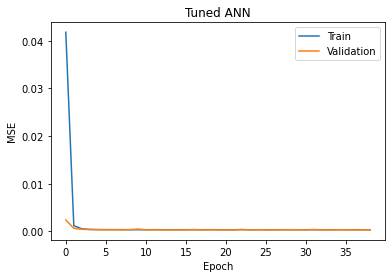

In [27]:
def visualising_data(hist, name):
    plt.title('Tuned ANN')
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_mean_squared_error'], label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name)
    plt.show()
visualising_data(hypermodel_hist, '/Users/jackkelly/Desktop/Building_Model/Figures/hypermodel_results.png')

In [10]:
# shows weights of the ANN
# hypermodel.weights
hypermodel.summary()
# print(hypermodel.metrics_names)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 204)               8568      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                8200      
Total params: 16,768
Trainable params: 16,768
Non-trainable params: 0
_________________________________________________________________


In [11]:
# INSERT SOMETHING THAT CALCUALTES ALL MEAN SQUARED ERRORS AND PLOTS ON CDF GRAPH

In [12]:
# best_hps.__dict__.keys()
# best_hps.__dict__['values']
hypermodel.save('/Users/jackkelly/Desktop/Building_Model/Tuned_' + str(N_channels) + '_channels_ANN_model_v2.h5')

# Transfer Learning

In [13]:
def transfer_learning(model_path):
    hypermodel = keras.models.load_model(model_path)
    hypermodel.summary()
    model = tf.keras.Sequential()
    for layer in hypermodel.layers[:-1]: # go through until last layer
        layer.trainable=False
        model.add(layer)
    model.add(keras.layers.Dense(40, activation='sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

In [14]:
# hypermodel = keras.models.load_model('Tuned_' + str(N_channels) + '_channels_ANN_model.h5')

In [15]:
# hypermodel.summary()

In [16]:
# model = tf.keras.Sequential()
# for layer in hypermodel.layers[:-1]: # go through until last layer
#     layer.trainable=False
#     model.add(layer)
# model.add(keras.layers.Dense(40, activation='sigmoid'))
# model.summary()

# model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])

In [17]:
model = transfer_learning('Tuned_' + str(N_channels) + '_channels_ANN_model_v2.h5')
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_variedlengths_10000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 204)               8568      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                8200      
Total params: 16,768
Trainable params: 16,768
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 204)               8568      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                8200      
Total params: 16,768
Trainable params: 8,200
Non-trainable params: 8,568
_________________________________________________________________


In [18]:
start_time = time.time()
new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
training_time = time.time() - start_time
print(training_time)

Train on 7000 samples, validate on 1500 samples
Epoch 1/40
7000/7000 [==============================] - ETA: 1:18 - loss: 0.2077 - mean_squared_error: 0.20 - ETA: 3s - loss: 0.1731 - mean_squared_error: 0.1730 - ETA: 1s - loss: 0.1585 - mean_squared_error: 0.15 - ETA: 0s - loss: 0.1483 - mean_squared_error: 0.14 - ETA: 0s - loss: 0.1405 - mean_squared_error: 0.14 - ETA: 0s - loss: 0.1324 - mean_squared_error: 0.13 - ETA: 0s - loss: 0.1254 - mean_squared_error: 0.12 - ETA: 0s - loss: 0.1185 - mean_squared_error: 0.11 - 1s 166us/sample - loss: 0.1149 - mean_squared_error: 0.1148 - val_loss: 0.0686 - val_mean_squared_error: 0.0685
Epoch 2/40
7000/7000 [==============================] - ETA: 0s - loss: 0.0718 - mean_squared_error: 0.07 - ETA: 0s - loss: 0.0633 - mean_squared_error: 0.06 - ETA: 0s - loss: 0.0607 - mean_squared_error: 0.06 - ETA: 0s - loss: 0.0571 - mean_squared_error: 0.05 - ETA: 0s - loss: 0.0540 - mean_squared_error: 0.05 - ETA: 0s - loss: 0.0511 - mean_squared_error: 0.0

7000/7000 [==============================] - ETA: 0s - loss: 6.4200e-04 - mean_squared_error: 5.4439e- - ETA: 0s - loss: 7.5946e-04 - mean_squared_error: 6.6184e- - ETA: 0s - loss: 7.5680e-04 - mean_squared_error: 6.5919e- - ETA: 0s - loss: 7.5125e-04 - mean_squared_error: 6.5364e- - ETA: 0s - loss: 7.6296e-04 - mean_squared_error: 6.6534e- - ETA: 0s - loss: 7.6225e-04 - mean_squared_error: 6.6464e- - ETA: 0s - loss: 7.6190e-04 - mean_squared_error: 6.6429e- - ETA: 0s - loss: 7.5846e-04 - mean_squared_error: 6.6085e- - ETA: 0s - loss: 7.5323e-04 - mean_squared_error: 6.5562e- - 1s 79us/sample - loss: 7.5192e-04 - mean_squared_error: 6.5431e-04 - val_loss: 7.2963e-04 - val_mean_squared_error: 6.3202e-04
Epoch 14/40
7000/7000 [==============================] - ETA: 0s - loss: 6.0629e-04 - mean_squared_error: 5.0867e- - ETA: 0s - loss: 7.0943e-04 - mean_squared_error: 6.1181e- - ETA: 0s - loss: 7.0858e-04 - mean_squared_error: 6.1096e- - ETA: 0s - loss: 6.9328e-04 - mean_squared_error: 5.

7000/7000 [==============================] - ETA: 0s - loss: 4.1217e-04 - mean_squared_error: 3.1455e- - ETA: 0s - loss: 3.8552e-04 - mean_squared_error: 2.8791e- - ETA: 0s - loss: 3.7789e-04 - mean_squared_error: 2.8028e- - ETA: 0s - loss: 3.7430e-04 - mean_squared_error: 2.7669e- - ETA: 0s - loss: 3.8008e-04 - mean_squared_error: 2.8246e- - ETA: 0s - loss: 3.7559e-04 - mean_squared_error: 2.7798e- - ETA: 0s - loss: 3.7523e-04 - mean_squared_error: 2.7761e- - ETA: 0s - loss: 3.7609e-04 - mean_squared_error: 2.7848e- - ETA: 0s - loss: 3.7620e-04 - mean_squared_error: 2.7858e- - 1s 80us/sample - loss: 3.7656e-04 - mean_squared_error: 2.7894e-04 - val_loss: 3.7518e-04 - val_mean_squared_error: 2.7757e-04
Epoch 25/40
7000/7000 [==============================] - ETA: 0s - loss: 4.1611e-04 - mean_squared_error: 3.1849e- - ETA: 0s - loss: 3.5779e-04 - mean_squared_error: 2.6018e- - ETA: 0s - loss: 3.6931e-04 - mean_squared_error: 2.7170e- - ETA: 0s - loss: 3.7049e-04 - mean_squared_error: 2.

Epoch 36/40
7000/7000 [==============================] - ETA: 0s - loss: 2.5040e-04 - mean_squared_error: 1.5278e- - ETA: 0s - loss: 2.6397e-04 - mean_squared_error: 1.6636e- - ETA: 0s - loss: 2.6073e-04 - mean_squared_error: 1.6311e- - ETA: 0s - loss: 2.6221e-04 - mean_squared_error: 1.6459e- - ETA: 0s - loss: 2.6450e-04 - mean_squared_error: 1.6689e- - ETA: 0s - loss: 2.6321e-04 - mean_squared_error: 1.6560e- - ETA: 0s - loss: 2.6215e-04 - mean_squared_error: 1.6454e- - ETA: 0s - loss: 2.6075e-04 - mean_squared_error: 1.6314e- - ETA: 0s - loss: 2.5980e-04 - mean_squared_error: 1.6219e- - 1s 78us/sample - loss: 2.5882e-04 - mean_squared_error: 1.6121e-04 - val_loss: 2.5837e-04 - val_mean_squared_error: 1.6076e-04
Epoch 37/40
7000/7000 [==============================] - ETA: 0s - loss: 3.2527e-04 - mean_squared_error: 2.2766e- - ETA: 0s - loss: 2.6272e-04 - mean_squared_error: 1.6510e- - ETA: 0s - loss: 2.6087e-04 - mean_squared_error: 1.6326e- - ETA: 0s - loss: 2.5812e-04 - mean_squar

In [19]:
# evaluating transfer-learned model
eval_result = model.evaluate(X_test, Y_test, verbose=1)
# evaluating OLD model with new data
hypermodel_result = hypermodel.evaluate(X_test, Y_test, verbose=0)
print(eval_result)
print(hypermodel_result)

1500/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 0s 46us/sample - loss: 1.9905e-04 - mean_squared_error: 1.3361e-04
[0.00023122231596304723, 0.00013360877]
[0.0008090754775330424, 0.0007114619]


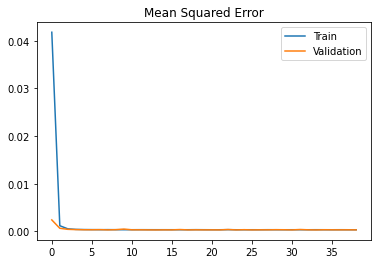

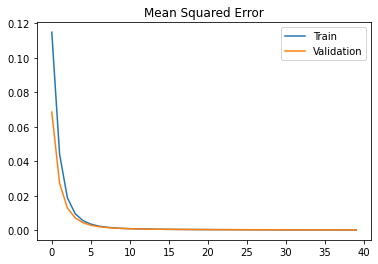

In [20]:
# visualising_data(hypermodel_hist)
# visualising_data(model.history)

In [21]:
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_variedlengths_EDFAs_10000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
start_time = time.time()
new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=0, batch_size=N_channels+1)
training_time = time.time() - start_time
print(training_time)
# evaluating transfer-learned model
value_new = model.evaluate(X_test, Y_test, verbose=0)
# evaluating new model
value_old = hypermodel.evaluate(X_test, Y_test, verbose=0)
print(value_new)
print(value_old)

19.54207730293274
[0.0002075995944129924, 0.00010998606]
[0.0008206666878735026, 0.0007230531]
